In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

from sklearn import metrics


# set display option
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# ignore warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
plt.rcParams['font.size'] = 14


# Utility functions

In [2]:
# Regression: Feature selection of the given dataset for model building
def feature_ranking(X, Y, colnames):
    '''
    This function is used to select relevant features for the machine learning model. 
    Feature Selection is the method of reducing the input variable to the model by using 
    only relevant data and getting rid of noise in data. 
    Input:
        X: Predictor variable
        Y: Label/target variable
        colnames: Name of the predictor variable
    
    Output:
        
        meanplot: Mean ranking of the predictor variable for features selection/ranking
    
    '''
    # Define dictionary to store our rankings
    ranks = {}
    # Create our function which stores the feature rankings to the ranks dictionary
    def ranking(ranks, names, order=1):
        minmax = MinMaxScaler()
        ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
        ranks = map(lambda x: round(x,2), ranks)
        return dict(zip(names, ranks))

    # Construct Recursive Feature Elimination (RFE) of the Linear Regression model
    lr = LinearRegression()
    lr.fit(X,Y)

    #stop the search when only the last feature is left
    rfe = RFE(lr, n_features_to_select=1, ) #verbose =3
    rfe.fit(X,Y)
    ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

    # Decision Tree Regressor
    dt = DecisionTreeRegressor()
    dt.fit(X,Y)
    ranks["DT"] = ranking(dt.feature_importances_, colnames)

    # Random Forest Regressor
    rf = RandomForestRegressor(n_jobs=-1, n_estimators=9) #verbose=3
    rf.fit(X,Y)
    ranks["RF"] = ranking(rf.feature_importances_, colnames)

    """ Creating the Feature Ranking Matrix: We combine the scores from the various methods above and output 
    it in a matrix form for convenient viewing as such:"""

    # Create empty dictionary to store the mean value calculated from all the scores
    r = {}
    for name in colnames:
        r[name] = round(np.mean([ranks[method][name] for method in ranks.keys()]), 2)


    methods = sorted(ranks.keys())
    ranks["Mean"] = r
    methods.append("Mean")

    # Put the mean scores into a Pandas dataframe
    meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

    # Sort the dataframe
    meanplot = meanplot.sort_values('Mean Ranking', ascending=False)
    
    return meanplot



###############################################

# Regression: Feature selection of the given dataset for model building
def feature_ranking_classifier(X, Y, colnames):
    '''
    This function is used to select relevant features for the machine learning model. 
    Feature Selection is the method of reducing the input variable to the model by using 
    only relevant data and getting rid of noise in data. 
    Input:
        X: Predictor variable
        Y: Label/target variable
        colnames: Name of the predictor variable
    
    Output:
        
        meanplot: Mean ranking of the predictor variable for features selection/ranking
    
    '''
    # Define dictionary to store our rankings
    ranks = {}
    # Create our function which stores the feature rankings to the ranks dictionary
    def ranking(ranks, names, order=1):
        minmax = MinMaxScaler()
        ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
        ranks = map(lambda x: round(x,2), ranks)
        return dict(zip(names, ranks))

    # Construct Recursive Feature Elimination (RFE) of the Linear Regression model
    lr = LogisticRegression(random_state= 42)  
    lr.fit(X,Y)

    #stop the search when only the last feature is left
    rfe = RFE(lr, n_features_to_select=1, ) #verbose =3
    rfe.fit(X,Y)
    ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

    # Decision Tree Regressor
    dt = DecisionTreeClassifier()
    dt.fit(X,Y)
    ranks["DT"] = ranking(dt.feature_importances_, colnames)

    # Random Forest Regressor
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=9, ) #verbose=3
    rf.fit(X,Y)
    ranks["RF"] = ranking(rf.feature_importances_, colnames)

    """ Creating the Feature Ranking Matrix: We combine the scores from the various methods above and output 
    it in a matrix form for convenient viewing as such:"""

    # Create empty dictionary to store the mean value calculated from all the scores
    r = {}
    for name in colnames:
        r[name] = round(np.mean([ranks[method][name] for method in ranks.keys()]), 2)


    methods = sorted(ranks.keys())
    ranks["Mean"] = r
    methods.append("Mean")

    # Put the mean scores into a Pandas dataframe
    meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

    # Sort the dataframe
    meanplot = meanplot.sort_values('Mean Ranking', ascending=False)
    
    return meanplot

# Data understanding and data preparation

This section details the data understanding and preparation of the traffic flow prediction dataset. In this section, Created the train and test dataframe from the traffic flow prediction dataset for machine learning. Restructured the dataset and added columns like sensor_id derived from the ‘36 sensors’ and merged the predictor and target/label variables. The following two functions are used to create the dataframe from the traffic flow prediction dataset.

fn_create_label() This function is used to create the label/target variable from the traffic flow prediction dataset. The create_label() function takes input as df_name- Name of the Dataframe and y_size- the size of contiguous quarter hours. This function returns the result as the df- Dataframe.

fn_concat_x() fn_concat_x() function is used to create the predictor variable. The fn_concat_x() takes input as df_name- Name of the Dataframe and y_size: the size of contiguous quarter hours. The fn_concat_x() function returns the result as the df- Dataframe.

Performed the data understanding by printing a few rows of the dataframe and checked the missing values and data type etc. of the traffic flow dataset.

Export the merged training and testing dataset into CSV file format for further analysis and analytics.

In [3]:
# read .CSV files
trainDf = pd.read_csv("Daily Demand Forecasting Orders.csv", index_col=0)
trainDf

Week of the month (first week, second, third, fourth or fifth week  Day of the week (Monday to Friday)  Non-urgent order  Urgent order  Order type A  Order type B  Order type C  Fiscal sector orders  Orders from the traffic controller sector  Banking orders (1)  Banking orders (2)  Banking orders (3)  Target (Total orders)
0                                                   1                                                    4           316.307       223.270        61.543       175.586       302.448                 0.000                                      65556               44914              188411               14793                539.577
1                                                   1                                                    5           128.633        96.042        38.058        56.037       130.580                 0.000                                      40419               21399               89461                7679                224.675
2                                                   1                                                    6            43.651        84.375        21.826        25.125        82.461                 1.386                                      11992                3452               21305               14947                129.412
3                                                   2                                                    2           171.297       127.667        41.542       113.294       162.284                18.156                                      49971               33703               69054               18423                317.120
4                                                   2                                                    3            90.532       113.526        37.679        56.618       116.220                 6.459                                      48534               19646               16411               20257                210.517
5                                                   2                                                    4           110.925        96.360        30.792        50.704       125.868                79.000                                      52042                8773               47522               24966                207.364
6                                                   2                                                    5           144.124       118.919        43.304        66.371       153.368                 0.000                                      46573               33597               48269               20973                263.043
7                                                   2                                                    6           119.379       113.870        38.584        85.961       124.413                15.709                                      35033               26278               56665               18502                248.958
8                                                   3                                                    2           218.856       124.381        33.973       148.274       162.044                 1.054                                      66612               19461              103376               10458                344.291
9                                                   3                                                    3           146.518       101.045        36.399        43.306       168.723               865.000                                      58224                7742               82395               11948                248.428
10                                                  3                                                    4           178.433       102.793        45.706       111.036       124.678               194.000                                      47046               17299              108719               15560                281.420
11                                                  3   

In [4]:
# print the info of train dataframe
trainDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 59
Data columns (total 13 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Week of the month (first week, second, third, fourth or fifth week  60 non-null     int64  
 1   Day of the week (Monday to Friday)                                  60 non-null     int64  
 2   Non-urgent order                                                    60 non-null     float64
 3   Urgent order                                                        60 non-null     float64
 4   Order type A                                                        60 non-null     float64
 5   Order type B                                                        60 non-null     float64
 6   Order type C                                                        60 non-null     float64
 7   Fiscal sector order

In [5]:
# Check the missing values
trainDf.isnull().sum()

Week of the month (first week, second, third, fourth or fifth week    0
Day of the week (Monday to Friday)                                    0
Non-urgent order                                                      0
Urgent order                                                          0
Order type A                                                          0
Order type B                                                          0
Order type C                                                          0
Fiscal sector orders                                                  0
Orders from the traffic controller sector                             0
Banking orders (1)                                                    0
Banking orders (2)                                                    0
Banking orders (3)                                                    0
Target (Total orders)                                                 0
dtype: int64

In [6]:
# Alter the column name
trainDf.columns = trainDf.columns.str.replace(' ', '_')

# Exploratory Data Analysis (EDA)
This section discovers the trends and patterns in the dataset and understands the relationship between various variables.

Exploratory Data Analysis (EDA) is an approach we used to analyse the data using visual techniques. EDA is used to check assumptions with the help of statistical summaries and graphical representations.

In [7]:
from pandas_profiling import ProfileReport
ProfileReport(trainDf)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
trainDf.head()

Week_of_the_month_(first_week,_second,_third,_fourth_or_fifth_week  Day_of_the_week_(Monday_to_Friday)  Non-urgent_order  Urgent_order  Order_type_A  Order_type_B  Order_type_C  Fiscal_sector_orders  Orders_from_the_traffic_controller_sector  Banking_orders_(1)  Banking_orders_(2)  Banking_orders_(3)  Target_(Total_orders)
0                                                  1                                                    4           316.307       223.270        61.543       175.586       302.448                 0.000                                      65556               44914              188411               14793                539.577
1                                                  1                                                    5           128.633        96.042        38.058        56.037       130.580                 0.000                                      40419               21399               89461                7679                224.675
2                                                  1                                                    6            43.651        84.375        21.826        25.125        82.461                 1.386                                      11992                3452               21305               14947                129.412
3                                                  2                                                    2           171.297       127.667        41.542       113.294       162.284                18.156                                      49971               33703               69054               18423                317.120
4                                                  2                                                    3            90.532       113.526        37.679        56.618       116.220                 6.459                                      48534               19646               16411               20257                210.517

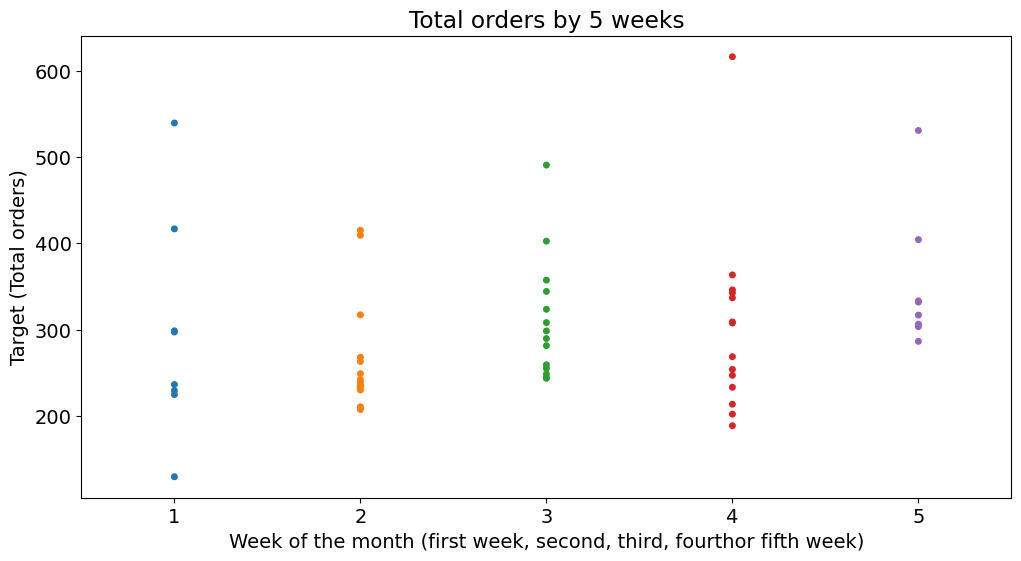

In [9]:
# Plot Total orders by 5 weeks using stripplot
f, ax = plt.subplots(figsize=(12, 6))
sns.stripplot(x="Week_of_the_month_(first_week,_second,_third,_fourth_or_fifth_week", y="Target_(Total_orders)", data=trainDf, jitter=False)
plt.title("Total orders by 5 weeks")
plt.xlabel('Week of the month (first week, second, third, fourthor fifth week)')
plt.ylabel('Target (Total orders)')
plt.show()

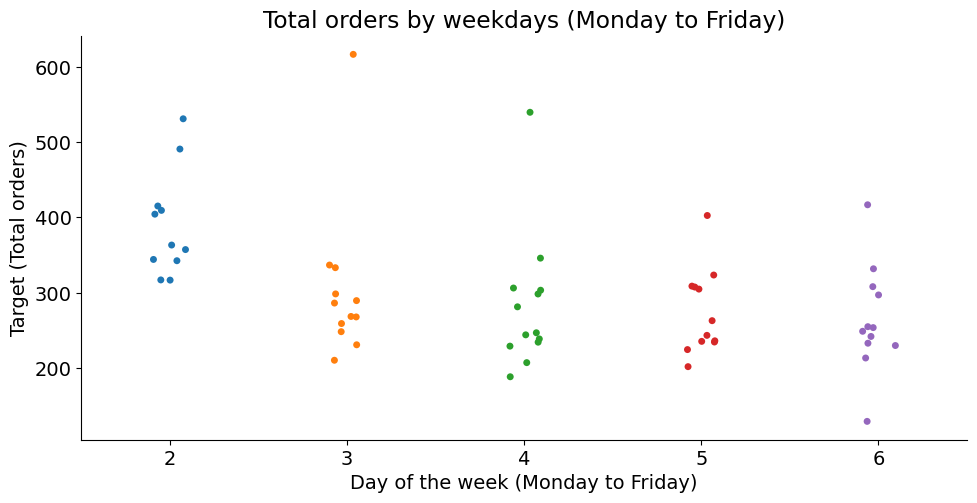

In [10]:
# plot Total orders by weekdays (Monday to Friday) uisng catplot
sns.catplot(x="Day_of_the_week_(Monday_to_Friday)", y="Target_(Total_orders)", data=trainDf, jitter=True, height=5,aspect=2)
plt.title("Total orders by weekdays (Monday to Friday)")
plt.xlabel('Day of the week (Monday to Friday)')
plt.ylabel('Target (Total orders)')
plt.show()

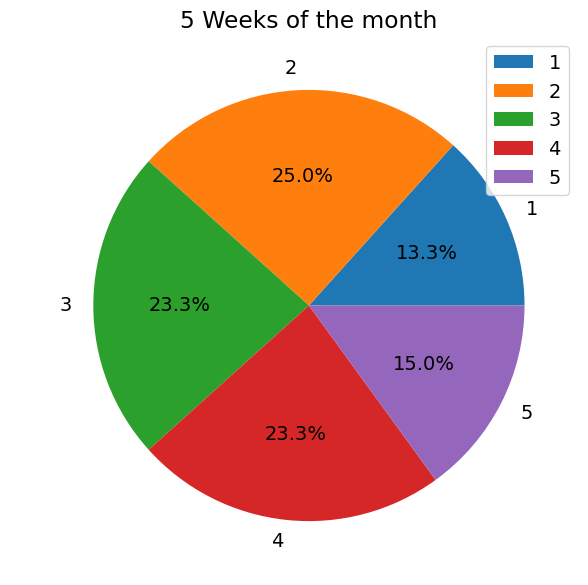

In [11]:
# Pie Chart
(trainDf.groupby('Week_of_the_month_(first_week,_second,_third,_fourth_or_fifth_week')['Week_of_the_month_(first_week,_second,_third,_fourth_or_fifth_week'].count()).plot.pie(autopct='%1.1f%%',figsize=(9,7), legend = True)
plt.title("5 Weeks of the month")
plt.ylabel(' ')
plt.show()

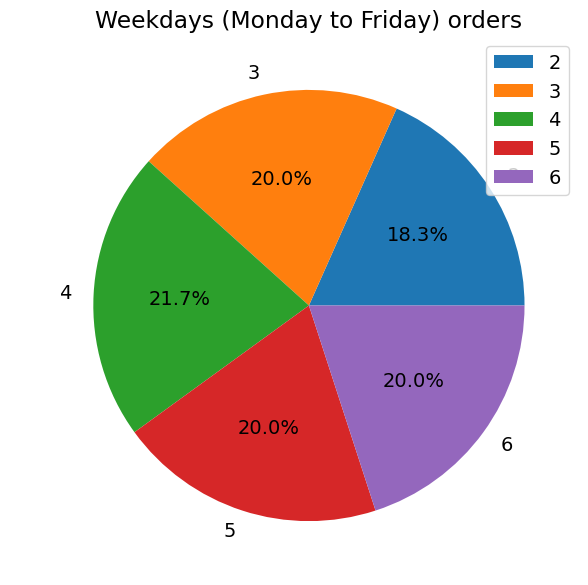

In [12]:
# Pie Chart
(trainDf.groupby('Day_of_the_week_(Monday_to_Friday)')['Day_of_the_week_(Monday_to_Friday)'].count()).plot.pie(autopct='%1.1f%%',figsize=(9,7), legend = True, )
plt.title("Weekdays (Monday to Friday) orders")
plt.ylabel(' ')
plt.show()

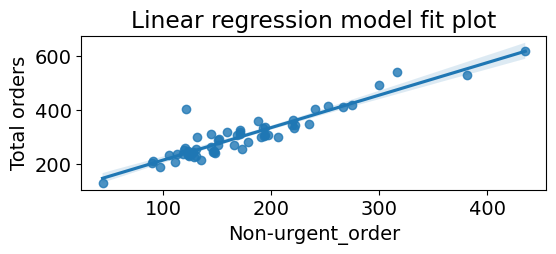

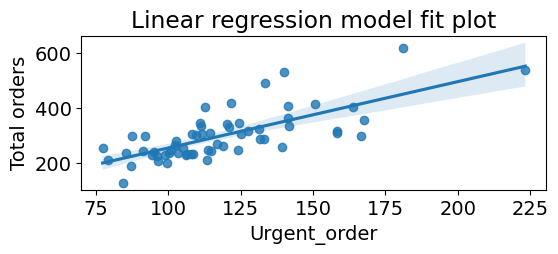

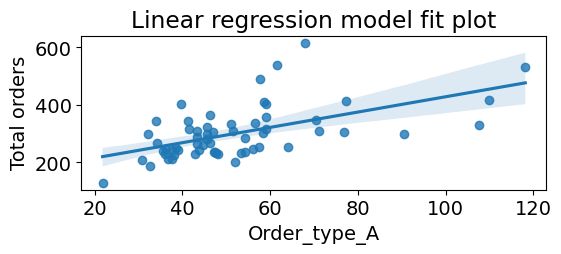

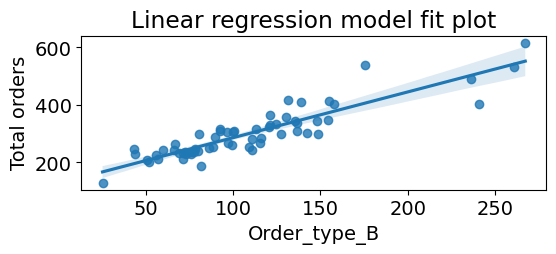

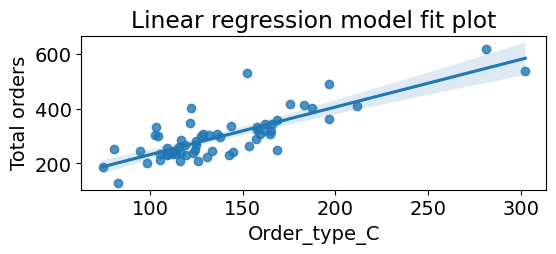

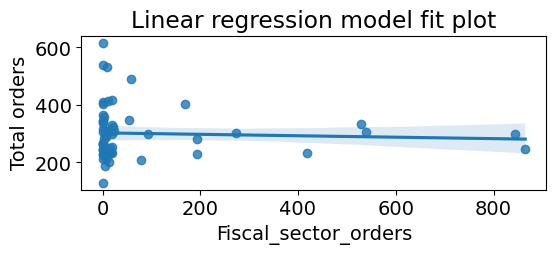

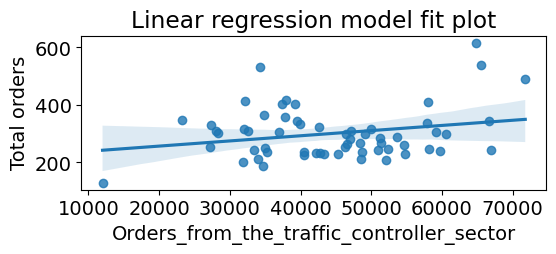

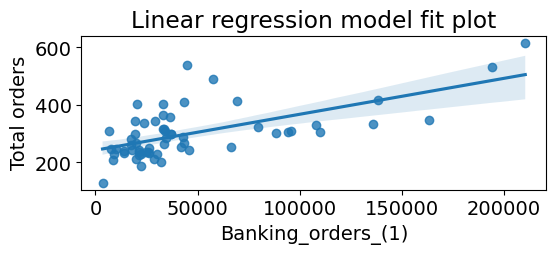

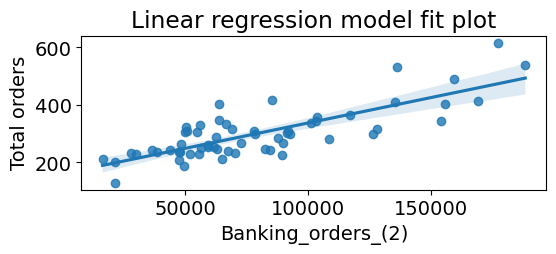

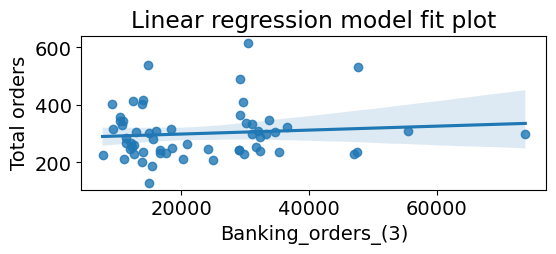

In [13]:
# Linear regression model fit plot
plotColumns =  trainDf[['Non-urgent_order', 'Urgent_order', 'Order_type_A', 'Order_type_B', 'Order_type_C', 
                        'Fiscal_sector_orders', 'Orders_from_the_traffic_controller_sector', 'Banking_orders_(1)', 
                        'Banking_orders_(2)', 'Banking_orders_(3)']]    
for col in plotColumns:
    f, ax = plt.subplots(figsize=(6, 2))
    ax = sns.regplot(x=plotColumns[col], y=trainDf["Target_(Total_orders)"], data=plotColumns)
    plt.title("Linear regression model fit plot")
    plt.xlabel(col)
    plt.ylabel('Total orders')
    plt.show()
    print("\n")
    
    

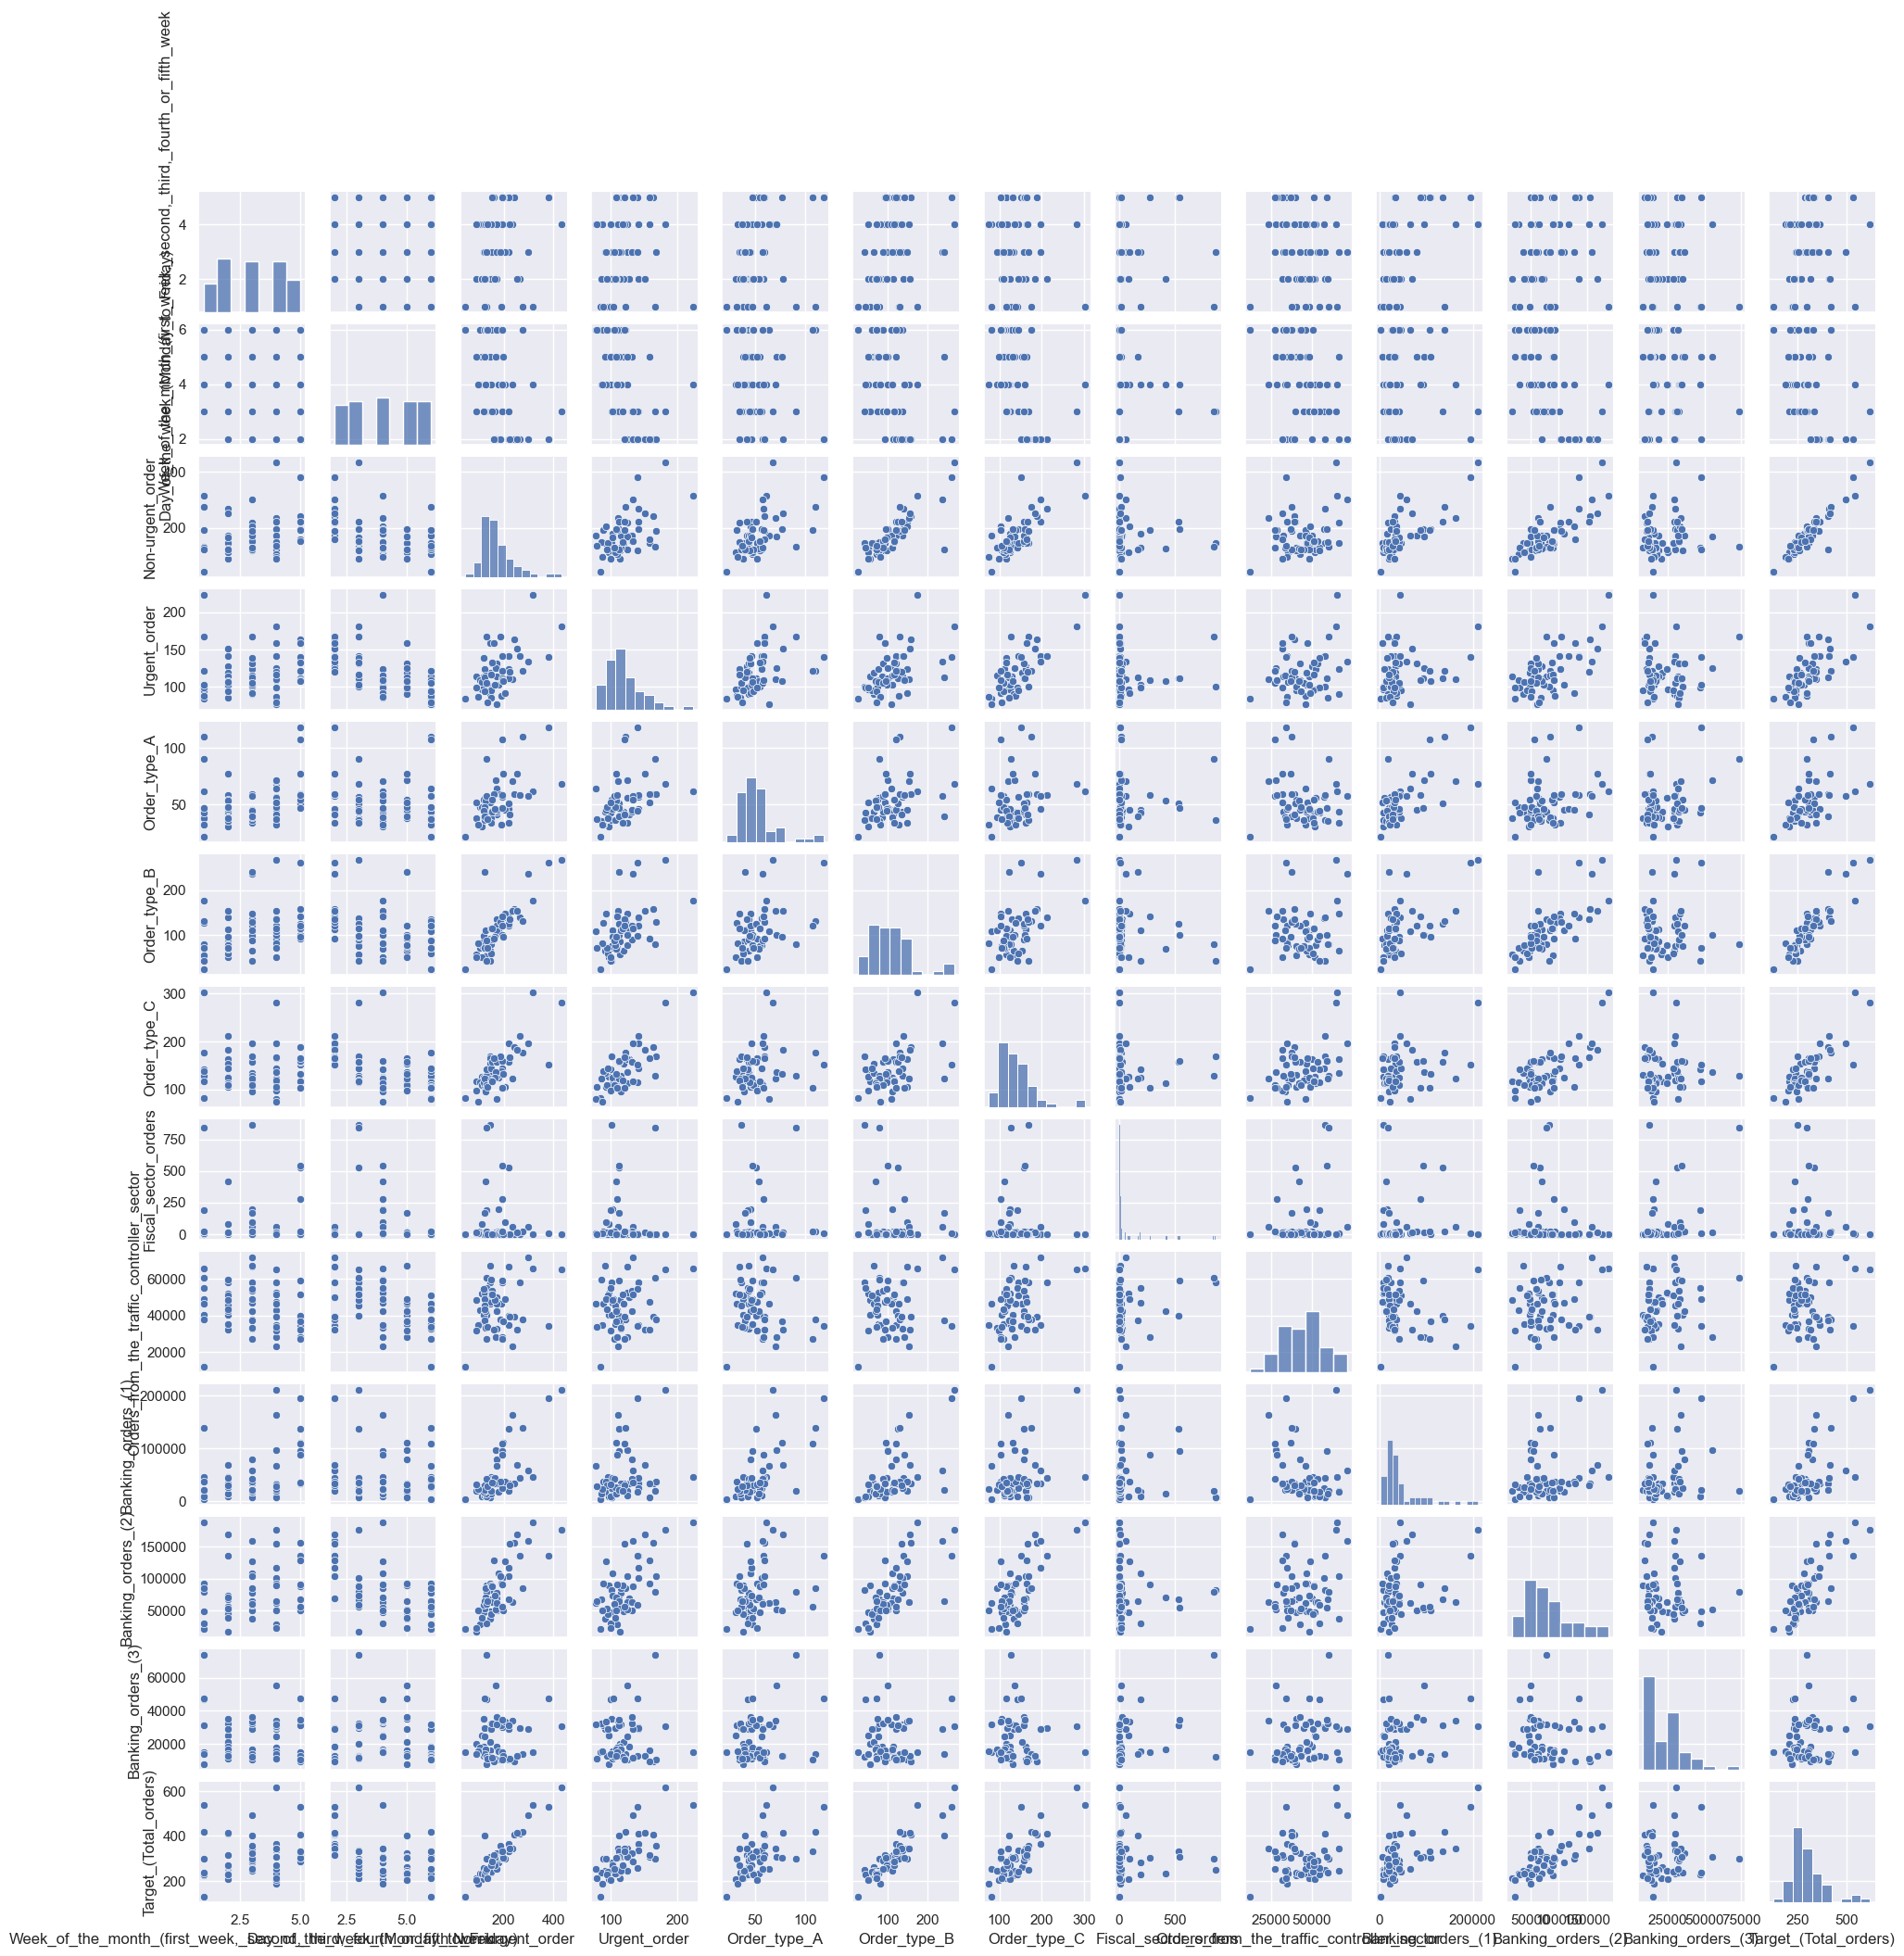

In [14]:
# pairplot
sns.set()
cols = trainDf.columns
sns.pairplot(trainDf[cols], size = 1.5)
plt.show()

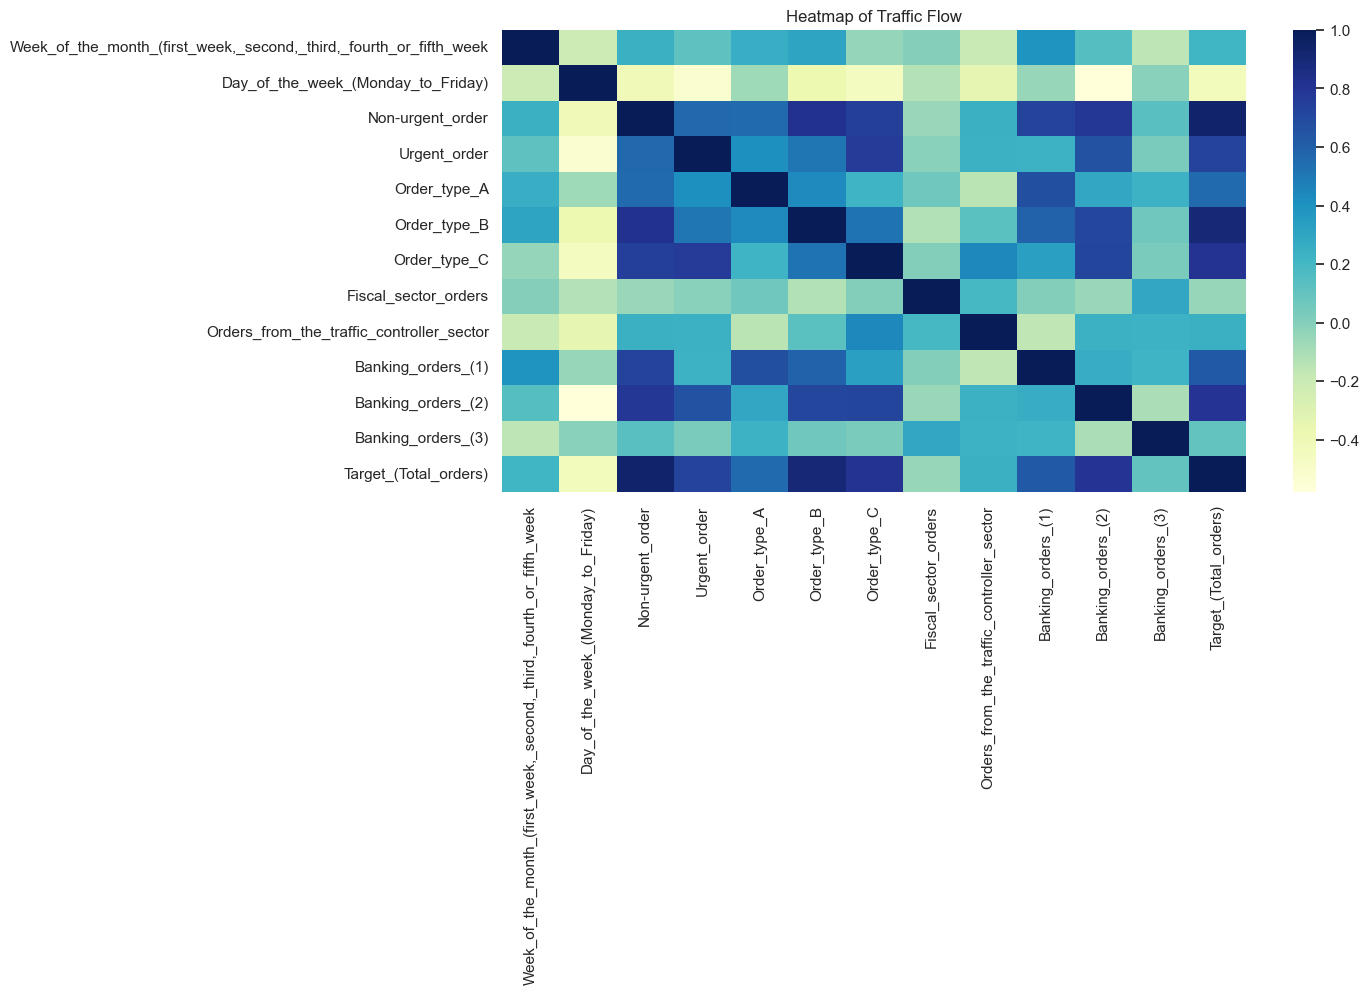

In [15]:
# Heatmap of Traffic Flow
f, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(trainDf.corr(), cmap="YlGnBu")
plt.title("Heatmap of Traffic Flow")
# displaying heatmap
plt.show()

# Regression: Significant Feature Ranking
This section details the importance of features for robust machine learning model building. Feature selection is the method of reducing the input variable to the model by using only relevant data and getting rid of noise in the data.

Build the python function for features ranking name called feature_ranking(). This function is used to select relevant features for the machine learning model. feature_ranking() takes the input as X- Predictor variable, Y - Label/target variable and colnames - Name of the predictor variable. feature_ranking() return the result as the meanplot - mean ranking of the predictor variable for features selection/ranking.

feature_ranking() method can be used as feature selection, variable selection, attribute selection or variable subset selection. In another word, feature selection is the process of selecting a subset of relevant features for use in model construction.

The following plot shows the mean ranking of features of the traffic flow prediction dataset

In [16]:
# Extract the input variable and target variable from trainDf
X = trainDf.drop(['Target_(Total_orders)'],  axis=1)

Y = trainDf[['Target_(Total_orders)']]

# Store the column/feature names into a list "colnames"
colnames = list(X.columns)

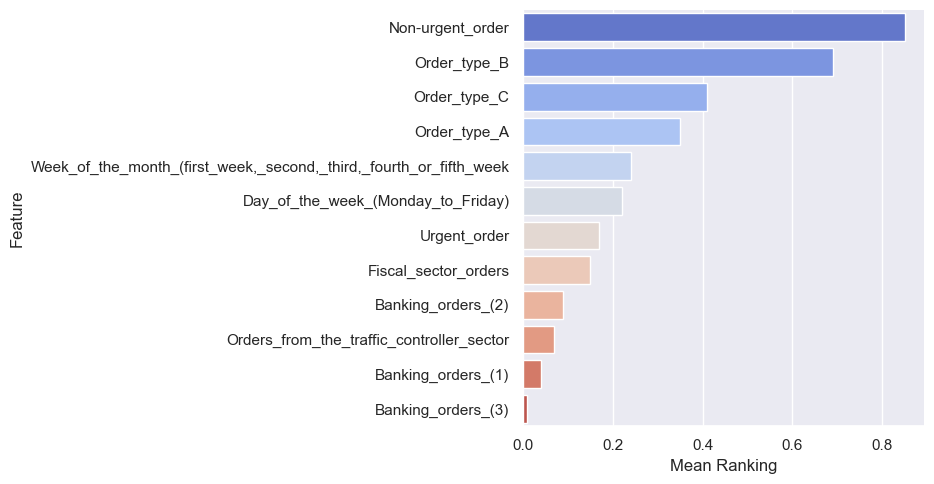

In [17]:
# Plot the ranking of the features
meanplot = feature_ranking(X,Y, colnames)

sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", 
               size=5, aspect=1.9, palette='coolwarm')

In [18]:
# sort the mean ranking of the features
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)
meanplot

Feature  Mean Ranking
2                                    Non-urgent_order          0.85
5                                        Order_type_B          0.69
6                                        Order_type_C          0.41
4                                        Order_type_A          0.35
0   Week_of_the_month_(first_week,_second,_third,_...          0.24
1                  Day_of_the_week_(Monday_to_Friday)          0.22
3                                        Urgent_order          0.17
7                                Fiscal_sector_orders          0.15
10                                 Banking_orders_(2)          0.09
8           Orders_from_the_traffic_controller_sector          0.07
9                                  Banking_orders_(1)          0.04
11                                 Banking_orders_(3)          0.01

In [19]:
# select the features based on Mean Ranking for model training
columnName = meanplot.loc[meanplot['Mean Ranking']  >= 0.30]
columnName = list(columnName.Feature)
print("No of Feature: ", len(columnName))
print("Columns Name: ", columnName)

No of Feature:  4
Columns Name:  ['Non-urgent_order', 'Order_type_B', 'Order_type_C', 'Order_type_A']


# Regression: Choosing machine learning algorithms for model training
Choosing machine learning algorithms for model training is one of the important steps in data mining. The choice of the machine learning algorithms is based on the given problem statement. For this linear problem statement chosen models are:

1. K-Neighbors Regressor
2. linear regression
3. Ridge regression models
4. Random forest regressor
5. decision tree
6. Support vector regressor

# Regression: Model training and evaluation

This section details machine learning model building and evaluation of the models. A prepared dataset was used to train and test the ML model performance. Split the training dataset into 70:30 ratios, where 70 portions were used for the model training and 30 portions were used for the model testing.

For model training, tried many permutations and combinations of features selection/ranking and trained and tested the chosen linear models. Finally, the Mean ranking of the features greater than equal to 0.05 (section 4) is selected for the ML model training.

The performance evaluation report includes the R2 Score, Mean Square Error(MSE) and Root Mean Square Error(RMSE) of the chosen ML models. The ML models performance evaluation report was sorted in descending order.

In [20]:
# Extract the input variable and target variable of the trainDF
X = trainDf[columnName]
y = trainDf[['Target_(Total_orders)']]

# split original data [i.e X and y] into 70:30 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
# Create the performance report as R2 Score, Mean Square Error(MSE), Root Mean Square Error(RMSE) of the given models
model_name = []
r2_score = []
mse = []
rmse = []

def regression_report(ModelName, model_object):
    '''
    This function Create the performance evaluation report as R2 Score, Mean Square Error(MSE), Root Mean Square Error(RMSE)
    and print Regression report of the given models
    Input
        ModelName: Name of the ML model
        model_object: Object of the initialized ML model
    Output
        Print Regression report of the given models
    
    '''
    model_object.fit(X_train, y_train)
    y_test_pred = model_object.predict(X_test)
    
    model_name.append(ModelName)
    # print("Model Name:", ModelName)
    r2 = round(metrics.r2_score(y_test, y_test_pred), 4)
    r2_score.append(r2)
    # print("r2_score:", r2)
    
    MeanSquareError = round(mean_squared_error(y_test, y_test_pred), 4)
    mse.append(MeanSquareError)
    # print("Mean Square Error", MeanSquareError)
    
    RootMeanSquareError = round(math.sqrt(mean_squared_error(y_test, y_test_pred)),4)
    rmse.append(RootMeanSquareError)
    # print("Root Mean Square Error", RootMeanSquareError)
    

# Train the Linear models
linears = {
    "Linear Regression": LinearRegression(normalize =True),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Support Vector Regression": SVR(),
    "Ridge Regression": Ridge(),
    "K-Neighbors Regressor" : KNeighborsRegressor(),
        }

for key, val in linears.items():
    regression_report(key,val)
    # print('\n')
    
# Train the Random Forest Regressor model
trees = [21,31,51]

for tree in trees:
    rf = RandomForestRegressor(n_estimators = tree)
    regression_report("Random Forest Regressor #tree: "+ str(tree), rf)
    # print('\n')

    
evaluation_poly = pd.DataFrame({'Model Name' : model_name,
                                'R-squared' : r2_score,
                                'MSE' : mse,
                                'RMSE' : rmse})

evaluation_poly.sort_values(['R-squared'], ascending=False, inplace = True)
print("Performance evaluation report of the models as: \n",  evaluation_poly)




Performance evaluation report of the models as: 
                           Model Name  R-squared         MSE      RMSE
0                  Linear Regression     1.0000      0.0000    0.0000
3                   Ridge Regression     1.0000      0.0000    0.0069
4              K-Neighbors Regressor     0.7808   1953.6754   44.2004
5  Random Forest Regressor #tree: 21     0.7442   2279.7151   47.7464
6  Random Forest Regressor #tree: 31     0.7111   2574.4919   50.7395
7  Random Forest Regressor #tree: 51     0.6905   2758.5383   52.5218
1            Decision Tree Regressor     0.4907   4538.6166   67.3693
2          Support Vector Regression    -0.2517  11155.0131  105.6173


# Regression: Model selection
The above result shows that the Linear Regression and Ridge Regression performs well according to the performance/regression report as R2 Score, Mean Square Error(MSE), Root Mean Square Error(RMSE) compared to other models such as Random forest regressor #tree: 31, Random forest regressor #tree: 21, Random Forest Regressor #tree: 51, K-Neighbors Regressor decision tree and support vector regressor. 

According to the performance evaluation report, the Linear Regression model is selected for further prediction and analytics.

# Classification: Significant Feature Ranking

This section details the importance of features for robust machine learning model building. Feature selection is the method of reducing the input variable to the model by using only relevant data and getting rid of noise in the data.

Build the python function for features ranking name called feature_ranking(). This function is used to select relevant features for the machine learning model. feature_ranking() takes the input as X- Predictor variable, Y - Label/target variable and colnames - Name of the predictor variable. feature_ranking() return the result as the meanplot - mean ranking of the predictor variable for features selection/ranking.

feature_ranking() method can be used as feature selection, variable selection, attribute selection or variable subset selection. In another word, feature selection is the process of selecting a subset of relevant features for use in model construction.

The following plot shows the mean ranking of features of the traffic flow prediction dataset

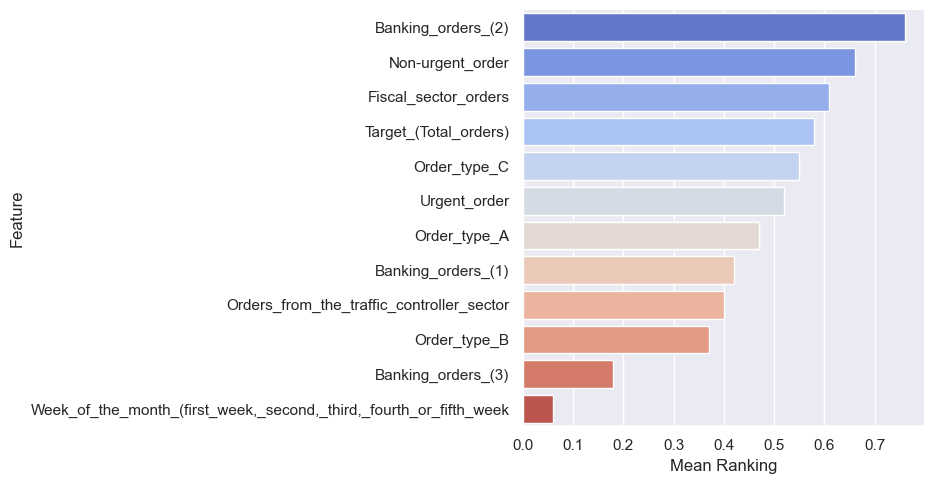

In [36]:
# Extract the input variable and target variable from trainDf
X = trainDf.drop(['Day_of_the_week_(Monday_to_Friday)'],  axis=1)

Y = trainDf[['Day_of_the_week_(Monday_to_Friday)']]

# Store the column/feature names into a list "colnames"
colnames = list(X.columns)

# Plot the ranking of the features
meanplot = feature_ranking_classifier(X,Y, colnames)

sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", 
               size=5, aspect=1.9, palette='coolwarm')

In [37]:
# sort the mean ranking of the features
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)
meanplot

Feature  Mean Ranking
9                                  Banking_orders_(2)          0.76
1                                    Non-urgent_order          0.66
6                                Fiscal_sector_orders          0.61
11                              Target_(Total_orders)          0.58
5                                        Order_type_C          0.55
2                                        Urgent_order          0.52
3                                        Order_type_A          0.47
8                                  Banking_orders_(1)          0.42
7           Orders_from_the_traffic_controller_sector          0.40
4                                        Order_type_B          0.37
10                                 Banking_orders_(3)          0.18
0   Week_of_the_month_(first_week,_second,_third,_...          0.06

In [38]:
# select the features based on Mean Ranking for model training
columnName = meanplot.loc[meanplot['Mean Ranking']  >= 0.02]
columnName = list(columnName.Feature)
print("No of Feature: ", len(columnName))
print("Columns Name: ", columnName)

No of Feature:  12
Columns Name:  ['Banking_orders_(2)', 'Non-urgent_order', 'Fiscal_sector_orders', 'Target_(Total_orders)', 'Order_type_C', 'Urgent_order', 'Order_type_A', 'Banking_orders_(1)', 'Orders_from_the_traffic_controller_sector', 'Order_type_B', 'Banking_orders_(3)', 'Week_of_the_month_(first_week,_second,_third,_fourth_or_fifth_week']


# Classification: Choosing machine learning algorithms for model training

Choosing machine learning algorithms for model training is one of the important steps in data mining. The choice of the machine learning algorithms is based on the given problem statement. For this classifier problem statement chosen models are:

1. Logistic Regression
2. Decision Tree Classifier
3. Support Vector Classifier
4. K-Neighbors Classifier
5. RandomForestClassifier
6. Naive Bayes


# Classification: Model training and evaluation

This section details machine learning model building and evaluation of the models. A prepared dataset was used to train and test the ML model performance. Split the training dataset into 70:30 ratios, where 70 portions were used for the model training and 30 portions were used for the model testing.

For model training, tried many permutations and combinations of features selection/ranking and trained and tested the chosen classifier models. Finally, the Mean ranking of the features greater than equal to 0.02 (section 4) is selected for the ML model training.

The performance evaluation report includes the Accuracy, Precision, Recall and f1-Score of the chosen ML models. The ML models performance evaluation report was sorted in descending order.

In [39]:
# Extract the input variable and target variable of the trainDF
X = trainDf[columnName]
y = trainDf[['Day_of_the_week_(Monday_to_Friday)']]

# split original data [i.e X and y] into 70:30 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# X_train

In [40]:
# Create the performance report as Accuracy, Precision, Recall and f1-Score of the given models
model_name = []
accuracy_score = []
roc_auc_score = []
precision_score = []
recall_score = []
f1_score = []


def classification_report(ModelName, model_object):
    '''
    This function Create the performance evaluation report as Accuracy, Precision, Recall and f1-Score of the given models
    Input
        ModelName: Name of the ML model
        model_object: Object of the initialized ML model
    Output
        Print Regression report of the given models
    
    '''
    model_object.fit(X_train, y_train)
    y_test_pred = model_object.predict(X_test)
    
    model_name.append(ModelName)
#     print("Model Name:", ModelName)
    
    r2 = round(metrics.accuracy_score(y_test, y_test_pred), 4)
    accuracy_score.append(r2)
#     print("accuracy_score:", r2)
    
    r2 = round(metrics.precision_score(y_test, y_test_pred, average='weighted'), 4)
    precision_score.append(r2)
    # print("precision_score:", r2)
    
    r2 = round(metrics.recall_score(y_test, y_test_pred, average='weighted'), 4)
    recall_score.append(r2)
    # print("recall_score:", r2)    
    
    r2 = round(metrics.f1_score(y_test, y_test_pred, average='weighted'), 4)
    f1_score.append(r2)
    # print("f1_score:", r2)
    

# Train the classifier models
linears = {
    "Logistic Regression": LogisticRegression(), #normalize =True
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Support Vector Classifier": SVC(),
    "Naive Bayes" : ComplementNB(),
    "K-Neighbors Classifier" : KNeighborsClassifier(),
        }


for key, val in linears.items():
    classification_report(key,val)
    # print('\n')
    
# Train the Random Forest Classifier model
trees = [21,31,51]

for tree in trees:
    rf = RandomForestClassifier(n_estimators = tree)
    classification_report("Random Forest Classifier #tree: "+ str(tree), rf)
    # print('\n')

    
evaluation_poly = pd.DataFrame({
                                'Model Name' : model_name,
                                'Accuracy' : accuracy_score,
                                'Precision' : precision_score,
                                'Recall' : recall_score,
                                'f1-Score' : f1_score,
                                })

evaluation_poly.sort_values(['Accuracy'], ascending=False, inplace = True)
print("Performance evaluation report of the models as: \n",  evaluation_poly)

Performance evaluation report of the models as: 
                            Model Name  Accuracy  Precision  Recall  f1-Score
7  Random Forest Classifier #tree: 51    0.5556     0.5907  0.5556    0.5400
0                 Logistic Regression    0.3889     0.5079  0.3889    0.4044
3                         Naive Bayes    0.3889     0.3889  0.3889    0.3806
6  Random Forest Classifier #tree: 31    0.3889     0.4056  0.3889    0.3832
5  Random Forest Classifier #tree: 21    0.3333     0.5635  0.3333    0.3287
1            Decision Tree Classifier    0.2778     0.3056  0.2778    0.2328
4              K-Neighbors Classifier    0.2778     0.3889  0.2778    0.3131
2           Support Vector Classifier    0.1667     0.2273  0.1667    0.1574


# Classification: Model selection

The above result shows that the Random Forest Classifier #tree: 51 performs well according to the performance/Classification report as Accuracy, Precision, Recall and f1-Score compared to other models such as Random forest Classifier #tree: 31, Random Forest Classifier #tree: 21, K-Neighbors Classifier decision tree, Support Vector Classifier and etc.

According to the performance evaluation report, the Random Forest Classifier #tree: 51 is selected for further prediction and analytics.

# Ensemble ML: Model training and evaluation

This section details machine learning model building and evaluation of the models. A prepared dataset was used to train and test the ML model performance. Split the training dataset into 70:30 ratios, where 70 portions were used for the model training and 30 portions were used for the model testing.

For model training, tried many permutations and combinations of features selection/ranking and trained and tested the chosen classifier models. Finally, the Mean ranking of the features greater than equal to 0.02 (section 4) is selected for the ML model training.

GridSearchCV technique is used for finding the optimal parameter values from a given set of parameters in a grid. GridSearchCV technique nothing but the essentially a cross-validation technique.

The performance evaluation report includes the Accuracy, Precision, Recall and f1-Score of the chosen ML models. The ML models performance evaluation report was sorted in descending order.

In [28]:
# Extract the input variable and target variable
X = trainDf[columnName]
y = trainDf[['Day_of_the_week_(Monday_to_Friday)']]


In [29]:
# Scaling: Since our columns are on different sacle it is important to perform scaling on them, this bring all variable to same range [0,1]

from sklearn import preprocessing
sx = preprocessing.MinMaxScaler()
sy = preprocessing.MinMaxScaler()

scaled_X = sx.fit_transform(trainDf.drop('Day_of_the_week_(Monday_to_Friday)',axis='columns'))
# scaled_X

In [30]:
# split original data [i.e X and y] into 70:30 
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3, random_state=42)
print("X_train",len(X_train))
print("X_test",len(X_test))
print("y_train",len(y_train))
print("y_test",len(y_test))


X_train 42
X_test 18
y_train 42
y_test 18


In [31]:
random_state = 42
classifier = [
            DecisionTreeClassifier(random_state = random_state),
            RandomForestClassifier(random_state = random_state),
            LogisticRegression(random_state = random_state),
            SVC(random_state = random_state),
            KNeighborsClassifier(),
            ComplementNB()
            ]


dt_param_grid = {"min_samples_split" : range(10,20),
                "max_depth": range(1,2)}

rf_param_grid = {"max_features": [1,3,10],
                "min_samples_split":[2,3,10],
                "min_samples_leaf":[1,3,10],
                "bootstrap":[False],
                "n_estimators":[11, 21,31,51],
                "criterion":["gini"]}

logreg_param_grid = {"C":np.logspace(-3,3,7),
                    "penalty": ["l2", ]}

svm_param_grid = {"kernel":['poly', 'rbf'],
                  "class_weight": ["balanced"],
                  "decision_function_shape": ['ovo', 'ovr']}

knn_param_grid = {"n_neighbors":[3,5,7],
                  "weights": ["uniform", "distance"],
                  "leaf_size": [20, 30,40,50]}

nb_param_grid = {"norm":[True],
                  "alpha": [0,1],
                  }


classifier_param = [dt_param_grid,
                   rf_param_grid,
                   logreg_param_grid,
                   svm_param_grid,
                   knn_param_grid,
                   nb_param_grid]


In [32]:
cv_result = []
best_estimators = []
for i in range(len(classifier)):
    clf = GridSearchCV(classifier[i], param_grid=classifier_param[i], cv = StratifiedKFold(n_splits = 5), scoring = "accuracy", n_jobs = -1,verbose = 1)
    clf.fit(X_train,y_train)
    cv_result.append(clf.best_score_)
    best_estimators.append(clf.best_estimator_)
    print("best_estimators", best_estimators)
    print("cv_result",cv_result[i])
    print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
best_estimators [DecisionTreeClassifier(max_depth=1, min_samples_split=10, random_state=42)]
cv_result 0.28888888888888886

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Fitting 5 folds for each of 108 candidates, totalling 540 fits
best_estimators [DecisionTreeClassifier(max_depth=1, min_samples_split=10, random_state=42), RandomForestClassifier(bootstrap=False, max_features=3, min_samples_leaf=3,
                       n_estimators=21, random_state=42)]
cv_result 0.4638888888888889

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Fitting 5 folds for each of 7 candidates, totalling 35 fits
best_estimators [DecisionTreeClassifier(max_depth=1, min_samples_split=10, random_state=42), RandomForestClassifier(bootstrap=False, max_features=3, min_samples_leaf=3,
                       n_estimators=21, random_state=42), LogisticRegression(C=1000.0, random_state=42)]
cv_result 0.40555555555555556

!!!!!!!!!!!!!!!!!!!!

Text(0.5, 1.0, 'Cross Validation Scores')

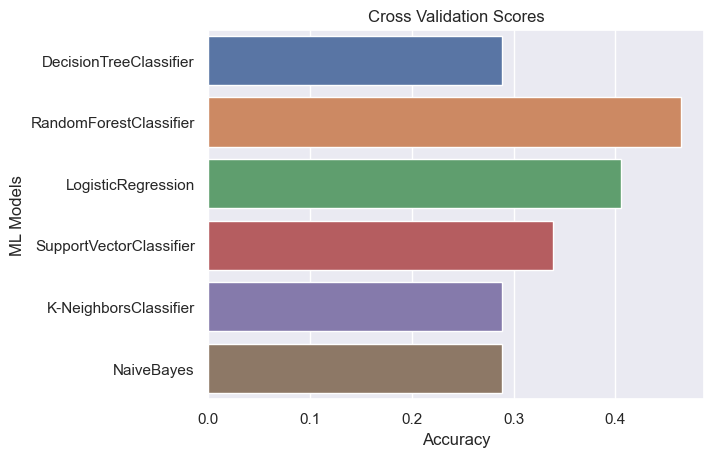

In [33]:
cv_results = pd.DataFrame({"Cross Validation Means":cv_result, "ML Models":["DecisionTreeClassifier", "RandomForestClassifier",
             "LogisticRegression", "SupportVectorClassifier",  "K-NeighborsClassifier", 'NaiveBayes']})

g = sns.barplot("Cross Validation Means", "ML Models", data = cv_results)
g.set_xlabel("Accuracy")
g.set_title("Cross Validation Scores")

# Ensemble ML Modeling

In [34]:
votingC = VotingClassifier(estimators = [("dt", best_estimators[1]),
                                        ("rfc", best_estimators[2]),
                                        ("nb", best_estimators[5])],
                                        voting = "soft", n_jobs = -1)
votingC = votingC.fit(X_train, y_train)
print(round(metrics.accuracy_score(votingC.predict(X_test),y_test),4))

0.5556


# Ensemble ML: Model selection

The above result shows that the Random Forest Classifier, Decision Tree and Naive Bayes performs well according to the Accuracy performance metrics compared to other ML models.

Tried many permutations and combinations of features selection/ranking and trained and tested the chosen ensemble classifier models. Finally, the ensemble of Random Forest Classifier, Decision Tree and Naive Bayes ML model is selected for further prediction and analytics.